In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import scipy.stats as st
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sns.set_theme(style="whitegrid")
sns.set_palette("Set2")

# What is the recipe for the perfect movie in **BOLLYWOOD** vs. in **HOLLYWOOD**?

## Data loading

### CMU dataset

| Column name          | Description                                                                                                                                                                                       |   |   |   |
|----------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|---|---|---|
| wikipedia_movie_id | ID of the movie from wikipedia                                                                                                                                                 |   |   |   |
| freebase_movie_id| ID of the movie from freebas                                                                                                                                            |   |   |   |
| movie_name | Name of the movie                                                                                                                                                |   |   |   |
| movie_release_date  | Date the movie was released                                                                                                                                      |   |   |   |
| movie_box_office_revenue  | Revenue of the movie box office                                                                                                                           
| movie_runtime  | Run time of the movie                                                                                                                                                 |   |   |   |
| movie_languages | Languages of the movie                                                                                                                                                  |   |   |   |
| movie_countries | Countries where the movie were created                                                                                                                                  |   |   |   |
| movie_genres   | Genre of the movie                                                                                                                                              |   |   |   |

The movie data set contains 81741 rows.



In [ ]:
data_folder = './data/'

names = ['wikipedia_movie_id','freebase_movie_id', 'movie_name', 'movie_release_date', 'movie_box_office_revenue', 
        'movie_runtime', 'movie_languages', 'movie_countries', 'movie_genres']

movies_data = pd.read_csv(data_folder + 'movie.metadata.tsv', names = names, sep = '\t', )

movies_data[['movie_name', 'movie_languages', 'movie_countries', 'movie_genres']]= movies_data[['movie_name', 'movie_languages', 'movie_countries', 'movie_genres']].applymap(lambda x: str.lower(x))

movies_data.head()

### IMdb datasets (ratings, runtimes, isAdult)

In [ ]:
#rating files loading
ratings = pd.read_csv(data_folder + 'title.ratings.tsv.gz', sep='\t', compression='gzip')
titles = pd.read_csv(data_folder + 'title.basics.tsv.gz', sep='\t', compression='gzip')

## Preprocessing

### IMdb and CMU datasets merging

In [ ]:
#merging IMdb dataset with title, isAdult and runtimeMinutes with dataset with averageRating on movie ID (tconst)
rates = titles.merge(ratings, how='left', on='tconst')[['averageRating', 'numVotes', 'originalTitle', 'isAdult', 'runtimeMinutes']]

#putting all titles to lower case to match the CMU dataset movie names and dropping column with upper cases
rates['movie_name'] = [ele.lower() for ele in rates['originalTitle'].astype(str)]
rates=rates.drop(columns='originalTitle')

#dropping all rows that have a movie name appearing multiple times so the merging on movie name with the CMU dataset is precise
rates = rates.drop_duplicates('movie_name', keep=False)

#converting runtimeMinutes to float and changing '\\N' to NaN to match the format in CMU dataset
rates['runtimeMinutes']=list(map(lambda x: float(x) if x!='\\N' else None , rates['runtimeMinutes']))

In [ ]:
#merging CMU dataset with the IMdb dataset
movies_data_merged = movies_data.merge(rates, how = 'left', on='movie_name')

#completing the NaN values in movie_runtime of the CMU dataset with the available ones of the IMdb dataset.
#we trust more the CMU dataset than the IMdb one so we give priority to the runtime values of the CMU dataset
# to the IMdb ones and use the IMdb only if the value is missing in the CMU.
#finally we drop the column with the IMdb runtimes.
movies_data_merged.loc[movies_data_merged['movie_runtime'].isna(), 'movie_runtime']=movies_data_merged.loc[movies_data_merged['movie_runtime'].isna(), 'runtimeMinutes']
movies_data_merged=movies_data_merged.drop(columns='runtimeMinutes')

In [ ]:
#finally creating the datasets with all indian movies and all american movies
indian_movies = movies_data_merged[movies_data_merged['movie_countries'] == '{"/m/03rk0": "india"}'].reset_index()
american_movies = movies_data_merged[movies_data_merged['movie_countries'] == '{"/m/09c7w0": "united states of america"}'].reset_index()

print('There are %d indian films and %d american films in the dataset' % (len(indian_movies), len(american_movies)))

## Asserting purity

In [ ]:
print('wiki ID, indian: ', len(indian_movies.drop_duplicates('wikipedia_movie_id')), '\nfreebase ID, indian: ', len(indian_movies.drop_duplicates('freebase_movie_id')))
print('wiki ID, american: ', len(american_movies.drop_duplicates('wikipedia_movie_id')), '\nfreebase ID, american: ', len(american_movies.drop_duplicates('freebase_movie_id')))

Our indian and american movies data base both do not contain any duplicates on either wikipedia movie ID nor freebase ID.

## Missing values

In [ ]:
indian_movies.info()

In [ ]:
american_movies.info()

We notice that the movie box office revenue is very often unavailable and present in very limited number in both datasets. Thus we probably won't use it for further analysis.

The informations merged from the IMdb dataset (averageRating, numVotes and isAdult) are available in almost the half of the dataset which makes them still usable despite an important loss of data points.

## Analysis of ratings

### Some global infos about ratings

In [ ]:
print('%.3f percent of indian movies have a rating and %.3f percent of american movies have a rating' %
(100-np.sum(indian_movies['averageRating'].isna())/indian_movies.shape[0]*100, 100-np.sum(american_movies['averageRating'].isna())/american_movies.shape[0]*100))

print('Average rating of indian movies : %.3f \tAverage rating of american movies : %.3f' %
(np.mean(indian_movies['averageRating']), np.mean(american_movies['averageRating'])))

### Distributions of movie ratings

In [ ]:
plt.figure(figsize=(7,3))
sns.histplot(x='averageRating', data=american_movies, alpha=0.5, label='American', stat = 'density', binrange=[0,10], bins = 20, kde=True)
sns.histplot(x='averageRating', data=indian_movies, alpha=0.5, color='orange', stat = 'density', label='Indian', binrange=[0,10], bins = 20, kde=True)
plt.title('Distribution of movies ratings')
plt.legend()
plt.show()

In [ ]:
print('P-value for normality test of american ratings : %.10f \tP-value for normality test of indian ratings : %.10f ' 
      % (st.normaltest(american_movies['averageRating'], nan_policy='omit').pvalue, st.normaltest(indian_movies['averageRating'], nan_policy='omit').pvalue))

Indian and american movies get similar distributions of ratings. This will allow us to use more easily the ratings as an unbiased tool to estimate the success of a movie.

### Distribution of number of votes

In [ ]:
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
sns.histplot(american_movies['numVotes'], bins=np.logspace(0,7,50), alpha =.5, binrange=[0., 1e7], stat = 'density')
sns.histplot(indian_movies['numVotes'], bins=np.logspace(0,7,50), alpha=.5, binrange=[0., 1e7], color = 'orange', stat = 'density')
plt.legend(labels=["American movies","Indian movies"])
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Number of votes')
plt.title('Number of votes per film, differenciated by movie coutry')

plt.subplot(2,2,2)
sns.boxplot(data = pd.DataFrame({'USA': american_movies['numVotes'], 'India': indian_movies['numVotes']}))
plt.yscale('log')
plt.title('Distribution of votes per film, differenciated by movie coutry')
plt.show()

In this plot we can see that the distributions follow similar patterns, except in the extrems. Proportionally, indian movies have more films with few votes (less than 100 votes), and, inversly, american movies have a movies that exceed the maximum number of votes any indian film obtains

In average, american films receive more votes, but Indian films receive enough votes so that we can deem their ratings reliable

### Centering the data around each means for further analysis

In [ ]:
#center data on mean
indian_movies.loc[:,'centeredRating']=indian_movies['averageRating'].copy()-np.mean(indian_movies['averageRating'])
american_movies.loc[:,'centeredRating']=american_movies['averageRating'].copy()-np.mean(american_movies['averageRating'])
print('Centered average rating of indian movies : %.3f \tCentered average rating of american movies : %.3f' %
(np.mean(indian_movies['centeredRating']), np.mean(american_movies['centeredRating'])))

## Runtimes analysis

### Some global infos about runtimes

In [ ]:
print('%.3f percent of indian movies have a runtime and %.3f percent of american movies have a runtime' %
(100-np.sum(indian_movies['movie_runtime'].isna())/indian_movies.shape[0]*100, 100-np.sum(american_movies['movie_runtime'].isna())/american_movies.shape[0]*100))

print('Average runtime of indian movies : %.3f \tAverage runtime of american movies : %.3f' %
(indian_movies['movie_runtime'].mean(), american_movies['movie_runtime'].mean()))


### Distribution of movie runtimes

In [ ]:
data_runtime = pd.DataFrame({'USA': american_movies.query('movie_runtime < 10000')['movie_runtime'], 'India': indian_movies.query('movie_runtime < 10000')['movie_runtime']})
sns.histplot(data = data_runtime)
plt.yscale('log')
plt.legend(labels=["American movies","Indian movies"])
plt.title(f'Distribution of runtimes (outlier of removed)')
plt.show()

From this plot we can see that we have a few outliers in both datasets. Looking at most of the films that are longer than 1000 minutes (16 hours), we decided that they could be discarted as they are either errors or not pertinent to our analysis (series of films instead of single film).

In [ ]:
print('Number of films longer than 16 hours:', len(indian_movies.query('movie_runtime > 1000')) + len(american_movies.query('movie_runtime > 1000')))

Deleting 8 films that are very likely to be errors shouldn't make default to our analysis

In [ ]:
# deleting films with runtime longer than 6 hours

indian_movies = indian_movies.query('movie_runtime < 1000')
american_movies = american_movies.query('movie_runtime < 1000')

In [ ]:
#defining number of bins to get roughly equal width between the 2 histograms
data_runtime = pd.DataFrame({'USA': american_movies['movie_runtime'], 'India': indian_movies['movie_runtime']})
#plotting
plt.figure(figsize=(15,15))

plt.subplot(2,2,1)
sns.histplot(american_movies['movie_runtime'], alpha =.5, stat = 'density', bins = 100, binrange= [0,1000])
sns.histplot(indian_movies['movie_runtime'], alpha=.5, color = 'orange', stat = 'density', bins = 100, binrange= [0,1000])
plt.yscale('log')
plt.legend(labels=["American movies","Indian movies"])
plt.xlabel('Movie runtime')
plt.title('Movie runtime, differenciated by movie coutry')


plt.subplot(2,2,2)
sns.violinplot(data = data_runtime)
plt.ylabel('Minutes')
plt.title(f'Distribution of runtimes (outlier of removed)')

plt.show()

In [ ]:
print('median runtime difference:', np.nanmedian(american_movies['movie_runtime'] - indian_movies['movie_runtime']))

We notice that indian movies have a tendancy to be longer by ~56 minutes and that there are a lot of short american movies, perhaps the oldest films from the dataset.

There could thus be a bias in our dataset, because early indian cinema might be under-represneted compared to early american cinema. We will investigate this bias when differentiating with respects to time.

It would be interesting to further study the evolution of these tendancies through time and integrate runtime to our analysis. Do we tend to a global equilibrium in the runtimes between indian and american movies revealing a standardization?

## Numbers of Indian vs American movies per year

In [ ]:
indian_movies_years = indian_movies.copy()

#slice the movie release date column to only have the years, and transform them as integer again
indian_movies_years['movie_release_date'] = indian_movies['movie_release_date'].dropna().astype('str').apply(lambda s: s[0:4]).astype('int')

#count the numbers of movies per year there are for indian movies
n_movie_per_year_indian = indian_movies_years.groupby('movie_release_date')['movie_name'].agg(['count'])

#change the movie release date as a column
n_movie_per_year_indian = pd.DataFrame(n_movie_per_year_indian).reset_index()

#sort the values
n_movie_per_year_indian['movie_release_date'] = n_movie_per_year_indian['movie_release_date'].sort_values()

n_movie_per_year_indian

In [ ]:
american_movies_years = american_movies.copy()

#slice the movie release date column to only have the years, and transform them as integer again
american_movies_years['movie_release_date'] = american_movies['movie_release_date'].dropna().astype('str').apply(lambda s: s[0:4]).astype('int')

#count the numbers of movies per year there are for american movies
n_movie_per_year_american = american_movies_years.groupby('movie_release_date')['movie_name'].agg(['count'])

#change the movie release date as a column
n_movie_per_year_american = pd.DataFrame(n_movie_per_year_american).reset_index()

#sort the values
n_movie_per_year_american['movie_release_date'] = n_movie_per_year_american['movie_release_date'].sort_values()

n_movie_per_year_american

Let us slice the data to have the same time frame: from 1912 to 2014 for both Indian and American movies.

In [ ]:
#Slice the data to have same time frame for both Indian and American movies data sets
n_movie_per_year_american = n_movie_per_year_american.query('movie_release_date <= 2014 & movie_release_date >= 1912')

In [ ]:
#Plot both Indian and American numbers of movies per year
sns.lineplot(data= n_movie_per_year_indian, x='movie_release_date', y = 'count', label='indian')
sns.lineplot(data= n_movie_per_year_american, x='movie_release_date', y = 'count', label='american')
plt.title('Indian vs American movies per year ')
plt.xlabel('Movie release year')
plt.ylabel('Number of movies per year')
plt.show()

We can observe a peak starting to grow from the 2000 years for both Hollywood and Bollywood movies.

In [ ]:
#Zoom in during the peak of Indian and American released movie years
sns.lineplot(data= n_movie_per_year_indian, x='movie_release_date', y = 'count', label='indian')
sns.lineplot(data= n_movie_per_year_american, x='movie_release_date', y = 'count', label='american')
plt.title('Indian vs American movies per year, from the 2000s')
plt.xlabel('Movie release year')
plt.ylabel('Number of movies per year')
plt.axis([2000, 2014, 0, 1000])
plt.show()

The peak of released movies are at 2006 for Hollywood and 2008 Bollywood respectively.

At 2014 it goes back to nearly 0 films released, but we should investigate carefully the data set that explain this lack of data.

Thus we begin the data set in 1950 for both Hollywood and Bollywood movies and cut the data set to 2006 for both Hollywood and Bollywood movies.


In [ ]:
# transform the movie release date column to only have the years, and transform them as integer again
indian_movies['movie_release_date'] = indian_movies['movie_release_date'].dropna().astype('str').apply(lambda s: s[0:4]).astype('int')
american_movies['movie_release_date'] = american_movies['movie_release_date'].dropna().astype('str').apply(lambda s: s[0:4]).astype('int')

# Cut the data from 1950 to 2006 to have the same time frame for both Indian and American movies data sets
cut_american_movies = american_movies.query('movie_release_date <= 2010 & movie_release_date >= 1980')
cut_indian_movies = indian_movies.query('movie_release_date <= 2010 & movie_release_date >= 1980')

## Movie genre analysis

In [ ]:
test_indian = indian_movies.copy()
#remove {}
test_indian['cleared_movie_genres'] = test_indian['movie_genres'].str[1:-1]
#remove films without genre
test_indian = test_indian.query("cleared_movie_genres != ''")

test_indian.head()

In [ ]:
#create list with all genres and count each genre number of apparation
all_genres_listed_indian = test_indian['cleared_movie_genres'].str.split(pat=",")

ls = []
for i in all_genres_listed_indian:
    ls.extend(i)
 
all_genres_indian = pd.Series(ls)
all_genres_indian = all_genres_indian.str.strip().value_counts()
all_genres_indian.index = [ele.split(':')[1][2:-1] for ele in all_genres_indian.index]

In [ ]:
#ploting the first 50 genres
first_genres_indian = all_genres_indian[:50]
f, ax = plt.subplots(figsize=(6, 10))
sns.barplot(y = first_genres_indian.index, x = first_genres_indian).set_title('Movie genres apparition in indian movies')
sns.despine(left=True, bottom=True)

In [ ]:
test_american = american_movies.copy()
#remove {}
test_american['cleared_movie_genres'] = test_american['movie_genres'].str[1:-1]
#remove films without genre
test_american = test_american.query("cleared_movie_genres != ''")
test_american.head()

In [ ]:
#create list with all genres and count each genre number of apparation
all_genres_listed_american = test_american['cleared_movie_genres'].str.split(pat=",")

ls = []
for i in all_genres_listed_american:
    ls.extend(i)
 
all_genres_american = pd.Series(ls)
all_genres_american = all_genres_american.str.strip().value_counts()
all_genres_american.index=[ele.split(':')[1][2:-1] for ele in all_genres_american.index]

In [ ]:
#ploting the first 50 genres
first_genres_american = all_genres_american[:50]
f, ax = plt.subplots(figsize=(6, 10))
sns.barplot(y = first_genres_american.index, x = first_genres_american).set_title('Movie genres apparition in American movies')
sns.despine(left=True, bottom=True)


To compare them with each other, we calculate the frequency of movie genre in each region

In [ ]:
#calculate frequencies of movie genre in each production
all_genres_american_frequency = all_genres_american/len(american_movies)
first_genres_american_frequency = all_genres_american_frequency[:50]
all_genres_indian_frequency = all_genres_indian/len(indian_movies)
first_genres_indian_frequency = all_genres_indian_frequency[:50]

In [ ]:
#ploting the first 50 genres
fig, ax = plt.subplots(1,2,figsize=(10, 10),sharex = True, constrained_layout=True)
fig.suptitle('Movie genres frequency in american and indian films')
ax[0].set_title('America')
ax[1].set_title('India')

sns.barplot(ax = ax[0],y = first_genres_american_frequency.index, x = first_genres_american_frequency, label="American", color="b")
sns.barplot(ax = ax[1], y = first_genres_indian_frequency.index, x = first_genres_indian_frequency, label="Indian", color="r")

In [ ]:
print("Indian movies have a total of %d different movies genres and american have %d" %(len(all_genres_indian.index), len(all_genres_american.index)))

As the plots show, "drama" is the prominent movie genre in both american and indian movies. However, american movies seems to have a better distribution of different genres than indian that are clearly more focused around "drama".

Furthermore, both of them have a large number of different movie genres which can make the analysis difficult. Moreover, genres like "silent film" or "world cinema" are not specific theme to categorize the movies. In the other hand, it seems that some genres are similar to each other or some of them include other genres (e.g. "action/aventure" can include "aventure"). In conclusion, for further analysis, it could be interesting to select a restricted group of movie genres that allows better and more precises results. 

### First analysis of movie genre across time

In [ ]:
test_american['movie_release_date']

In [ ]:
test_american = cut_american_movies.copy()
test_american = test_american.dropna(subset= 'movie_release_date')
test_american['movie_release_date'] = test_american['movie_release_date'].astype(str)
test_american['movie_release_date'] = test_american['movie_release_date'].str.slice(stop = 4)
test_american['cleared_movie_genres'] = test_american['movie_genres'].str[1:-1]
test_american = test_american.query("cleared_movie_genres != ''")
all_genre_american_time = pd.DataFrame(test_american['cleared_movie_genres'])
all_genre_american_time.index = test_american['movie_release_date'] 
all_genre_american_time = pd.DataFrame(all_genre_american_time.groupby(['movie_release_date'])['cleared_movie_genres'].apply(','.join).apply(lambda x: x.split(','))).explode('cleared_movie_genres')
all_genre_american_time['year'] = all_genre_american_time.index
all_genre_american_time['cleared_movie_genres']=[ele.split(':')[1][2:-1] for ele in all_genre_american_time['cleared_movie_genres']]

final = pd.crosstab(all_genre_american_time['year'], all_genre_american_time['cleared_movie_genres'])
#taking the first 30 genres
final = final[final.sum().sort_values(ascending= False)[:30].index]
#normalize by the number of genres per year
final = final.apply(lambda x: x/final.sum(axis = 1))

In [ ]:
#plotting the 30 first prominent movie genres presence across time
#a, f = plt.subplots(figsize = (10,10), constrained_layout=True)
#plt.stackplot(final[70:].index, final[70:].to_dict(orient = 'list').values(), labels = final.keys())
#f.legend(loc='upper left')
#f.tick_params(axis = 'x', rotation = 90)
#a.suptitle("30 first prominent movie genres presence across time")

As we can see, there a too much genres to correctly analyze this plot. This encourages to select the main genres to analyze.

## Movie language

In this section, we will investigate some disparities or resemblence of the available languages of the film.

### Indian movies

In [ ]:
indian_languages= indian_movies.copy()
#remove the {} in each rows
indian_languages['cleared_movie_languages'] = indian_languages['movie_languages'].str[1:-1]

#remove the films without any languages
indian_languages = indian_languages.query("cleared_movie_languages != ''")

In [ ]:
#Create a list with all languages
all_languages_listed_indian = indian_languages['cleared_movie_languages'].str.split(pat=",")

#Drop the NAs
all_languages_listed_indian = all_languages_listed_indian.dropna()

#Create a list with all the languages in it
ls = []
for i in all_languages_listed_indian:
    ls.extend(i)
 
#Count the total number of languages that are in the movies for each one of the languages
all_languages_indian = pd.Series(ls)

#Strip the strings and count the numbers of occurence of each languages
all_languages_indian = all_languages_indian.str.strip().value_counts()

all_languages_indian.head()

In [ ]:
all_languages_indian_code = all_languages_indian.copy()

#Put it as data frame
all_languages_indian_code= pd.DataFrame(all_languages_indian_code)

#Reset the index to have the index as column
all_languages_indian_code = all_languages_indian_code.reset_index()

#Rename the columns correctly
all_languages_indian_code = all_languages_indian_code.rename(columns={"index": "languages", 0:"count"})

#Remove the code part (that begins with "/m")
all_languages_indian_code['languages'] = all_languages_indian_code['languages'].apply(lambda s: re.sub(r'/m.+ "', '',s))

#Only take the top 20 languages to plot it 
top_20_ind = all_languages_indian_code.iloc[:20]

top_20_ind.head()

In [ ]:
#Plotting top 20 languages (39 in total for indian languages)
f, ax = plt.subplots(figsize=(6, 10))
sns.barplot(data = top_20_ind,y = 'languages', x = 'count').set_title('Languages apparition in Indian movies')
ax.set_xscale('log')
sns.despine(left=True, bottom=True)

### American films

In [ ]:
american_languages = american_movies.copy()
#Remove the {} in the column
american_languages['cleared_movie_languages'] = american_languages['movie_languages'].str[1:-1]

#Remove films without languages
american_languages = american_languages.query("cleared_movie_languages != ''")

In [ ]:
#Create list with all languages
all_languages_listed_american = american_languages['cleared_movie_languages'].str.split(pat=",")

#Drop the NAs
all_languages_listed_american = all_languages_listed_american.dropna()

#Create a list with all the languages in it
ls = []
for i in all_languages_listed_american:
    ls.extend(i)
 
all_languages_american = pd.Series(ls)

#Count the total number of languages that are in the movies for each one of the languages
all_languages_american = all_languages_american.str.strip().value_counts()

all_languages_american.head()

In [ ]:
all_languages_american_code =  all_languages_american.copy()

#Put it as data frame
all_languages_american_code = pd.DataFrame(all_languages_american_code)

#Reset the index to have the index as column
all_languages_american_code = all_languages_american_code.reset_index()

#Rename the columns correctly
all_languages_american_code = all_languages_american_code.rename(columns={"index": "languages", 0:"count"})

#Remove the code part (that begins with "/m")
all_languages_american_code['languages'] = all_languages_american_code['languages'].apply(lambda s: re.sub(r'/m.+ "', '',s))

#Only take the top 20 languages to plot it 
top_20_american = all_languages_american_code.iloc[:20]

top_20_american.head()

In [ ]:
#Plotting top 20 languages (111 in total for American movies)
f, ax = plt.subplots(figsize=(6, 10))
sns.barplot(data = top_20_american, y = 'languages', x = 'count').set_title('Languages apparition in American movies')
ax.set_xscale('log')
sns.despine(left=True, bottom=True)

In [ ]:
#Compute the frequency of top 20 for the American and Indian languages
all_languages_american_code['frequency'] = all_languages_american_code['count'] / all_languages_american_code['count'].sum()
first_languages_american_frequency = all_languages_american_code[:20]

all_languages_indian_code['frequency'] = all_languages_indian_code['count']/all_languages_indian_code['count'].sum()
first_languages_indian_frequency = all_languages_indian_code[:20]


In [ ]:
#Plotting taking the first 20 languages for American films and Indian movies
fig, ax = plt.subplots(1,2,figsize=(10, 10),sharex = True, constrained_layout=True)
fig.suptitle('Top 20 movie languages frequency in American and Indian movies')
ax[0].set_title('American movies')
ax[1].set_title('Indian movies')

sns.barplot(ax = ax[0],data = first_languages_american_frequency, y = 'languages', x = 'frequency', label="American", color="b")

sns.barplot(ax = ax[1], data = first_languages_indian_frequency, y = 'languages', x = 'frequency', label="Indian", color="r")

#Setting logarithmic scale 
ax[0].set_xscale('log')
ax[1].set_xscale('log')

### How many languages per movies there are, on average ?


In [ ]:
#Compute the number of ':' that represent the number of languages there are in each row for American movies
american_languages['n_languages'] = american_languages.cleared_movie_languages.str.count(':')

#Compute the number of ':' that represent the number of languages there are in each row for Indian movies
indian_languages['n_languages'] = indian_languages.cleared_movie_languages.str.count(':')

In [ ]:
#Drop the movies that do not have any languages
n_indian_lan = indian_languages['n_languages'].dropna()

n_american_lan = american_languages['n_languages'].dropna()

#Compute the t-test to compare the number of available languages per movies for Indian and American movies
t_test_languages = st.ttest_ind(n_indian_lan, n_american_lan)

t_test_languages.pvalue

print('p-value for languages: ',t_test_languages.pvalue, '\t', 'p-value is smaller than 0.05: ', t_test_languages.pvalue <0.05)

There is a significant difference of the numbers of languages spoken in American vs Indian movies, so it could be that there are underlying effects, like Hollywood are more exported abroad than Bollywood movies.

## Characters data

450'668 characters in raw data

134079 differents actor 

5794 differents actor in indian movies

59398 differents actors in american movies


In [ ]:
names = ['wikipedia_movie_id', 'freebase_movie_id', 'movie_release_date', 'character_name', 'actor_dob', 'actor_gender', 'actor_height', 'actor_ethnicity', 'actor_name', 'actor_age_at_movie_release', 'char_act_id', 'freebase_character_id', 'freebase_actor_id']
characters_data = pd.read_csv(data_folder + 'character.metadata.tsv', names = names, sep = '\t')

characters_data.head(10)

In [ ]:
# Putting every name in lower case
characters_data[['character_name', 'actor_name']] = characters_data[['character_name', 'actor_name']].applymap(lambda x: x if type(x)!=str else x.lower())

## Including ethnicities

Using the automatic query system from wikidata, we are able to retrieve the ethnicity of the actors based on the freebase ID in the actor_ethnicity column. For that we just map the matching id to the string-representation of the ethnicity for clarity

In [ ]:
actor_ethnicities = pd.read_csv('data/ethnicities.csv')[['freebaseID', 'name']]
actor_ethnicities = dict(zip(actor_ethnicities.freebaseID, actor_ethnicities.name))
characters_data['actor_ethnicity'] = characters_data['actor_ethnicity'].map(actor_ethnicities)

In [ ]:
# We split the dataset in two
# all_american_actors can contain duplicate actors, it deals with the films 
# and who plays in it, the age they have when the film is produced
#
# all_indian_actors contains data about individual actors, it doesn't contain duplicates

all_american_actors = characters_data[characters_data['wikipedia_movie_id'].isin(american_movies['wikipedia_movie_id'])]
all_indian_actors = characters_data[characters_data['wikipedia_movie_id'].isin(indian_movies['wikipedia_movie_id'])]

unique_american_actor = all_american_actors.drop_duplicates('actor_name')
unique_indian_actor = all_indian_actors.drop_duplicates('actor_name')

In [ ]:
# We add a column indicating the country the actor/actress works in before concatenating the datasets
unique_american_actor = unique_american_actor.assign(country = np.full(len(unique_american_actor), 'USA'))
unique_indian_actor = unique_indian_actor.assign(country = np.full(len(unique_indian_actor), 'India'))

all_american_actors = all_american_actors.assign(country = np.full(len(all_american_actors), 'USA'))
all_indian_actors = all_indian_actors.assign(country = np.full(len(all_indian_actors), 'India'))


#unique_indian_actor['country'] = np.full(len(unique_indian_actor), 'India')

# We make sure to only keep actors with positive age to get rid of the errors 
all_american_actors = all_american_actors[all_american_actors['actor_age_at_movie_release'] > 0.]
all_indian_actors = all_indian_actors[all_indian_actors['actor_age_at_movie_release'] > 0.]

feature_list_all_actors = ['actor_gender', 'actor_age_at_movie_release', 'country']
all_actors_merged = pd.concat([all_american_actors[feature_list_all_actors], all_indian_actors[feature_list_all_actors]], axis = 0)

feature_list_unique_actors = ['actor_name', 'actor_gender', 'actor_ethnicity', 'country']
unique_actors_merged = pd.concat([unique_american_actor[feature_list_unique_actors], unique_indian_actor[feature_list_unique_actors]], axis = 0)

# Adding a column to the dataset of the features of single actors for the number of films in our dataset they appear in
dict_number_of_film = characters_data['actor_name'].value_counts().to_dict()
unique_actors_merged['number_of_films'] = unique_actors_merged['actor_name'].map(dict_number_of_film)

In [ ]:
all_actors_merged.info()

In [ ]:
unique_actors_merged.info()

## Actor Age

To do analysis on age, it makes sense to count the same actors multiple times as they play in different films, we will thus not drop the duplicates for this part of the analysis

In [ ]:
print(all_american_actors.actor_age_at_movie_release.describe())
print(all_indian_actors.actor_age_at_movie_release.describe())

We can see that the mean age is similar in both cases, as well as the standard deviation. Looking at the different quartiles we cannot see significant distribution difference between the two groups. 

We can note, however, that we have significantly more available ages available for actors in american films as for actors in indian films (137'073 versus 31'201)

In [ ]:
st.ttest_ind(all_american_actors.actor_age_at_movie_release, all_indian_actors.actor_age_at_movie_release, equal_var=False)

We can reject the null hypothesis, that is, that the mean actor age from american and indian movies are the same

In [ ]:
sns.histplot(data = all_american_actors['actor_age_at_movie_release'], stat = 'density', discrete=True, color = 'blue', kde=True)
sns.histplot(data = all_indian_actors['actor_age_at_movie_release'], stat = 'density',discrete=True, color='red', kde=True)
plt.legend(labels=["American movies","Indian movies"])
plt.xlabel('Actor age')
plt.title('Distribution of actor age in indian and american movies')
plt.show()


There seems to be more teenagers cast in american films, this can be due to the popularity of 'teen movies' in the western world, but is more likely to be simply due to a bias in quantity of information about american movies. The wikipedia pages of american movies might be more detailed about american films, containing even information about characters that may have relatively low screen time, like the daughter of a secondary character etc..

Otherwise the distributions seem similar

## Actor Gender

In [ ]:
# We separate the datasets containing all actors by gender
# For american films
american_film_female = all_american_actors[all_american_actors['actor_gender'] == 'F']
american_film_male = all_american_actors[all_american_actors['actor_gender'] == 'M']

# And for indian films
indian_film_female = all_indian_actors[all_indian_actors['actor_gender'] == 'F']
indian_film_male = all_indian_actors[all_indian_actors['actor_gender'] == 'M']


In [ ]:
print('Number of american film actors we have the gender of is {0}, of which {1:.0%} are female'.format(
    len(american_film_male) + len(american_film_female), len(american_film_female)/(len(american_film_male) + len(american_film_female))))

print('Number of indian film actors we have the gender of is {0}, of which {1:.0%} are female'.format(
    len(indian_film_male) + len(indian_film_female), len(indian_film_female)/(len(indian_film_male) + len(indian_film_female))))

In [ ]:
plt.figure(figsize=(15,15))
plt.suptitle('Comparaison of actor gender and age in American and Indian films', size = 'xx-large')
plt.subplot(2,2,1)

sns.histplot(data = all_american_actors, x = 'actor_age_at_movie_release', hue = 'actor_gender', stat = 'density', discrete=True, kde=True)
plt.xlabel('Actor/actress age')
plt.title('Distribution of american film actor age with respect to gender')

plt.subplot(2,2,2)
sns.histplot(data = all_indian_actors, x = 'actor_age_at_movie_release', hue = 'actor_gender', stat = 'density', discrete=True, kde=True)

plt.xlabel('Actor/actress age')
plt.title('Distribution of indian film actor age with respect to gender')

plt.subplot(2,2,3)
sns.histplot(data = all_american_actors[all_american_actors['actor_gender'] == 'F'], x = 'actor_age_at_movie_release', stat = 'density', discrete=True, color='orange', kde=True)
sns.histplot(data = all_indian_actors[all_indian_actors['actor_gender'] == 'F'], x = 'actor_age_at_movie_release', stat = 'density', discrete=True, kde=True)
plt.legend(labels=["American movies","Indian movies"])
plt.title('Distribution of actress age, differenciated by country')

plt.subplot(2,2,4)
sns.histplot(data = all_american_actors[all_american_actors['actor_gender'] == 'M'], x = 'actor_age_at_movie_release', stat = 'density', discrete=True, color='orange', kde=True)
sns.histplot(data = all_indian_actors[all_indian_actors['actor_gender'] == 'M'], x = 'actor_age_at_movie_release', stat = 'density', discrete=True, kde=True)
plt.legend(labels=["American movies","Indian movies"])
plt.title('Distribution of actor age, differenciated by country')


plt.show()


We can also visualize the same phenomenon using boxplots

In [ ]:
sns.boxplot(data = all_actors_merged, y = 'actor_age_at_movie_release', x = 'country', hue= 'actor_gender')
plt.title('Other visualization of the differences in age distribution by gender and country of movie production')
plt.show()

There are very little differences between the distributions of actor age between the two movie industries, but a big difference between the distribution of actresses' age. We can see that in indian movies there is a big density peak in the low twenties and a rapid decline from the thirties onward. 

This difference is very stark and should be investigated further in the rest of our analysis, regarding time-wise changes and the prediction of movie success.

We can evaluate the significance of the difference between the mean age of actors and actresses

In [ ]:
print(st.ttest_ind(all_american_actors.loc[all_american_actors.actor_gender == 'F']['actor_age_at_movie_release'],all_american_actors.loc[all_american_actors.actor_gender == 'M']['actor_age_at_movie_release']))
print(st.ttest_ind(all_indian_actors.loc[all_indian_actors.actor_gender == 'F']['actor_age_at_movie_release'],all_indian_actors.loc[all_indian_actors.actor_gender == 'M']['actor_age_at_movie_release']))
print(st.ttest_ind(all_american_actors.loc[all_american_actors.actor_gender == 'F']['actor_age_at_movie_release'],all_indian_actors.loc[all_indian_actors.actor_gender == 'F']['actor_age_at_movie_release']))
print(st.ttest_ind(all_american_actors.loc[all_american_actors.actor_gender == 'M']['actor_age_at_movie_release'],all_indian_actors.loc[all_indian_actors.actor_gender == 'M']['actor_age_at_movie_release']))

All null hypotheses can be rejected at the alpha = 0.05 level, although the effects might mainly be driven by sample size 

## Number of films actors played in

In [ ]:
plt.figure(figsize=(15,15))
plt.suptitle('Number of films an actor plays in', size = 'xx-large')
plt.subplot(2,2,1)
sns.histplot(data = unique_actors_merged[unique_actors_merged['country'] == 'India'], bins = np.logspace(0,2, 10), x = 'number_of_films', hue = 'actor_gender', kde = True, stat = 'density').set(xscale="log")
plt.title('Number of films per actor in indian movies, differenciated by gender')
plt.subplot(2,2,2)
sns.histplot(data = unique_actors_merged[unique_actors_merged['country'] == 'USA'], bins = np.logspace(0,2, 10), x = 'number_of_films', hue = 'actor_gender', kde = True, stat = 'density').set(xscale="log")
plt.title('Number of films per actor in american movies, differenciated by gender')

plt.subplot(2,2,3)
sns.barplot(data = unique_actors_merged, y = 'number_of_films', x = 'country', hue= 'actor_gender')
plt.title('Resume of the differences in film numbers between countries, differentiated by gender')
plt.show()

In [ ]:
# counting the number of actors/actresses
unique_actors_merged[unique_actors_merged['number_of_films'] > 100].groupby(['country', 'actor_gender']).agg({'count'})

We probably have a bias in our dataset in the quantity of information we have in our dataset regarding the american films. We are far more likely to have the names of actors that make a single brief aparition in an american film. However regarding the other extreme, we can see that there a lot more ultra-prolific indian film actors than american film actors.

In both film industries we see however that most of the hyper-prolific actors are males, which is probably linked to the difference in carreer prospects with age.

This is once again a angle that could be included in further analysis regarding trends through time and film succes (ratings) prediction

## Actor ethnicity

In [ ]:
ethnicity_data = unique_actors_merged.groupby(['actor_ethnicity', 'country'], as_index=False)['actor_name'].agg({'count'})
ethnicity_data = pd.DataFrame(ethnicity_data.to_records())
ethnicity_data = ethnicity_data.set_index('actor_ethnicity')

#separate the dataset per country
ethnicity_data_india = ethnicity_data[ethnicity_data['country'] == 'India']
ethnicity_data_usa = ethnicity_data[ethnicity_data['country'] == 'USA']

# converting count into density
ethnicity_data_india['count'] = ethnicity_data_india.loc[:,'count'].div(len(ethnicity_data_india)).copy(deep=True)
ethnicity_data_usa['count'] = ethnicity_data_usa.loc[:,'count'].div(len(ethnicity_data_usa)).copy(deep=True)

ethnicity_data.head()

In [ ]:
plt.figure(figsize=(20,80))
plt.subplot(2,2,1)
plt.title('Ethnicity of actors ranked per frequency for movies produced in India')
sns.barplot(data = ethnicity_data_india, y = ethnicity_data_india.index,  x = 'count', orient='h', order=ethnicity_data_india.sort_values(by = 'count', ascending=False).index)
sns.despine(left=True, bottom=True)
plt.xlabel('Density')


plt.subplot(2,2,2)
plt.title('Ethnicity of actors ranked per frequency for movies produced in the USA')
sns.barplot(data = ethnicity_data_usa, y = ethnicity_data_usa.index,  x = 'count', orient='h', order=ethnicity_data_usa.sort_values(by = 'count', ascending=False).index)
sns.despine(left=True, bottom=True)
plt.xlabel('Density')

plt.show()

Unsurprisingly, most ethnicities represented in the american films are descendent of immigrants, and most ethnicities represented in indian films are indian or more generally south-Asian. Also unsurprisingly, There are a lot more different ethnicities represented in films produced in the US compared to films produced in India. This might be due to the US being a more cosmopolite country, and to the difference in amout of information we have in our dataset

We can try investigate further the differences in representations in the industies, looking at the ethnicities represented in both industries

In [ ]:
# negative values represent ethnicities more represented in the indian film industry, and vice versa
compared_ethnicities = (ethnicity_data_usa['count'] - ethnicity_data_india['count']).dropna()

plt.title('Relative difference in proportion of ethnicities between indian and american films')
sns.barplot(y = compared_ethnicities.index,  x = compared_ethnicities.values, orient='h', order=compared_ethnicities.sort_values(ascending=False).index)
sns.despine(left=True, bottom=True)
plt.xlabel('Relative density')
plt.show()

## Analysis of character data: conclusion

In [ ]:
print('Number of indian film actors we have every features for:', unique_actors_merged[unique_actors_merged['country'] == 'India'].dropna().shape[0])
print('Number of american film actors we have every features for:', unique_actors_merged[unique_actors_merged['country'] == 'USA'].dropna().shape[0])

In [ ]:
print('Number of indian film actors we have everything but ethnicity for:', unique_actors_merged[unique_actors_merged['country'] == 'India']['actor_gender'].shape[0])
print('Number of american film actors we have everything but ethnicity for:', unique_actors_merged[unique_actors_merged['country'] == 'USA']['actor_gender'].shape[0])

If we consider only actors where we have all the available informations (gender, country the actors plays in, and ethnicity) we only get 354 indian film actors and 1967 american film actors. This is not enough to perform an analysis through time while taking into account actor ethnicity.

On the other hand, we have substantially more data on gender so taking it into account could be interesting for time-wise analysis for example.

## Name clusters data

In [ ]:
names = ['character_name', 'actor_reference']
name_clusters_data = pd.read_csv(data_folder + 'name.clusters.txt', names = names, sep = '\t', )

name_clusters_data.head(10)

## **Tvtropes clusters data**

In [ ]:
#Read tv tropes data
tv_trope = pd.read_csv(data_folder + 'tvtropes.clusters.txt', sep='\t', names= ['character_type', 'instances'])

tv_trope.head()

### Formatting data

In [ ]:
#Remove {} strings
tv_trope['instances'] = tv_trope['instances'].str[1:-1]

split_tv = tv_trope.copy()

#Split on , and : to separate into different columns
split_tv = tv_trope['instances'].str.split('[,:]', expand=True)

#Name the columns accordingly
cleaned_tv = split_tv.rename(columns={split_tv.columns[1]: 'character_name', split_tv.columns[3]: 'movie_name', split_tv.columns[5]: 'char_act_id',split_tv.columns[7]: 'actor_name'})

#Drop the un-necessary columns
cleaned_tv = cleaned_tv.drop(columns=[0,2,4,6,8,9,10])

#Remove the ""
cleaned_tv = cleaned_tv.applymap(lambda s : re.sub(r'"', " ", s))

#Make everything lowercases 
cleaned_tv = cleaned_tv.applymap(lambda x: str.casefold(x))

characters = tv_trope.character_type

#Join to have the characters too 
final_tv = cleaned_tv.join(characters, how= 'left')

final_tv.head()

In [ ]:
#Check if there is any movies in the tv tropes present in our movie data set
list_ = final_tv['movie_name']

movies_data['movie_name'].where(movies_data['movie_name'].isin(list_))

In [ ]:
#Check if there is any actors in the tv tropes present in our movie data set
list_1 = final_tv['actor_name']

movies_data['movie_name'].where(movies_data['movie_name'].isin(list_1)).dropna()

# Creating features based on summaries data

In [ ]:
summaries = pd.read_csv(data_folder + 'plot_summaries.txt', sep = '\r', names = ['summaries'])
summaries = summaries['summaries'].str.split("\t", expand = True)
summaries = summaries.rename(columns= {0:'wikipedia_movie_id',1: 'summaries'})
summaries['summaries'] = summaries['summaries'].str.lower()
summaries['summaries'] = summaries['summaries'].str.replace('{{plot}}', '')
summaries['wikipedia_movie_id'] = summaries['wikipedia_movie_id'].astype(int)
summaries.head(10)

In [ ]:
indian_summaries = summaries[summaries['wikipedia_movie_id'].isin(cut_indian_movies['wikipedia_movie_id'])]
indian_summaries = indian_summaries.reset_index(drop = True)
indian_summaries.head()

In [ ]:
american_summaries = summaries[summaries['wikipedia_movie_id'].isin(cut_american_movies['wikipedia_movie_id'])]
american_summaries = american_summaries.reset_index(drop = True)
american_summaries.head()

In [382]:
summaries_topic = pd.concat([indian_summaries, american_summaries], ignore_index=True)

summaries_topic.head()

,wikipedia_movie_id,summaries
0,20663735,poovalli induchoodan is sentenced for six yea...
1,8388648,the film opens with madhav and sreenu playin...
2,4356664,"kishen has a suspicious-minded wife, kaajal ,..."
3,19174305,"tahaan lives with his grandfather , mother ha..."
4,3459677,"raj mittal , veer saxena and aryan kapoor ar..."


## LDA Topic Detection Analysis

### Data pre-processing

Each NLP task requires some sort of data pre-processing to make data eligible for modeling. We will perform the following steps:

- Removing punctuation
- Tokenization: Splitting sentences into word-sized chunks, called tokens.
- Stopwords removal: Stopwords are English words that don’t add any value to the analysis. Removing them will help the model to find patterns more easily.
- First names removal : since we want the topics of the movies, including the names of the character did not make sense to analyze the topics for our context of analysis. We decided to removed them.
- Words with fewer than three letters are removed.
- Lemmatization: Converting words to their base using morphological analysis.
- Make bigrams: a bigram is a sequence of two adjacent elements from a string that combines to generate a more understandable form (e.g., [“data” , “science”] => [“data science”]

In [ ]:
# Run in python console
import nltk; nltk.download('stopwords')
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [ ]:
# nltk stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

#Remove commom names from the summaries (list of 18'000 names)
names = pd.read_csv(data_folder + 'names.csv')

#Save the names as dataframe
names = pd.DataFrame(names)

#Casefold the names
names['names'] = names['names'].str.lower().astype('str')

#Append some list of names that we saw in the movies summaries to make sure they are in the list
list_names = {'names':['alex', 'bobby', 'jake', 'timmy', 'danny', 'nick', 'anna', 'benny', 'maggie', 'reggie', 'nicky', 'vincent', 'johnny', 'grace']}

names = names.append(pd.DataFrame(list_names))

#Append the stop words in the list of names, consider them as "stopwords" to be removed from the summaries
stop = list(np.append(names['names'].values, ['from', 'subject', 're', 'edu', 'use']))

#Finally, extend the stop_words from nltk with our customized stop list
stop_words.extend(stop)

In [ ]:
#Declare function that preprocess the sentences of the summaries (removing punctuations, transforming into lowercase tokens)
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [ ]:
#Transform into lowercase tokens and removing punctuations
summaries_words = list(sent_to_words(summaries_topic['summaries']))

We then decide to build and use bigrams to pursue our analysis.

In [ ]:
# Build the bigram model
bigram = gensim.models.Phrases(summaries_words, min_count=15, threshold=100) # higher threshold fewer phrases.

bigram_mod = gensim.models.phrases.Phraser(bigram)

In [ ]:
# Define functions for stopwords, bigrams and lemmatization

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

#Remove the stopwords in the summaries data
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

#Make the bigrams out of the summaries data
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

#Lemmatize the summaries keeping only nouns, ajdectives, verbs and adverbs (ref: https://spacy.io/api/annotation)
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags and len(token)>3])
    return texts_out

In [ ]:
# Remove the stopwords and first names
summaries_words_no_stopwords = remove_stopwords(summaries_words)

# Form bigrams
summaries_words_bigrams = make_bigrams(summaries_words_no_stopwords)

# Perform the lemmatization keeping only nouns, ajdectives, verbs and adverbs 
summaries_words_lemmatized = lemmatization(summaries_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

After pre-processing the summaries, let us create the dictionnary, the corpus and the term document frequency for the subsequent analysis.

In [ ]:
# Create the dictionary
id2word = corpora.Dictionary(summaries_words_lemmatized)

# Remove rare and common tokens

# Tokens are kept if they are contained in at least 15 documents 
min_wordcount = 15

# Tokens are kept if they are containted in no more than 30 % of the documents 
max_freq = 0.3

# Filter these extremes accordingly
id2word.filter_extremes(no_below=min_wordcount, no_above=max_freq)

# Create the corpus, using the bag-of-words (BoW) format: list of (token_id, token_count) tuples.
texts = summaries_words_lemmatized

corpus = [id2word.doc2bow(text) for text in texts]

##### How to choose the number of topics ? 

Let's initialize a function that computes coherences values based on several number of topics, so we can chose the optimal number of topics based on the best coherence value.

The parameters of the function are : 
- dictionary : Gensim dictionary 
- corpus : Gensim corpus
- texts : List of input texts
- limit : Max num of topics
- start : number of initial topics
- step : number of step for the next topic

The function returns :
- model_list : the list of LDA topic models
- coherence_values : the coherence value corresponding to the LDA model with its respective number of topics

In [ ]:
from gensim.models import CoherenceModel # spaCy for preprocessing

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=2):
    #Initialize seed
    seed = 1111
    #Initialize dict
    base_models = dict()
    #Initialize coherence values and model list 
    coherence_values = []
    model_list = []
    #Compute the LDA model for each num_topics in the start, limit, step range
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=seed)
        #Append the model to the list of models
        model_list.append(model)
        #Compute the coherence
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        #Append the coherence value
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

Let us then use it with the number of topics going from 2 to 20, with a step of 2.

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary = id2word, corpus = corpus, texts = texts, start=2, limit=20, step=2)

Let us plot each coherence value for each model of LDA.

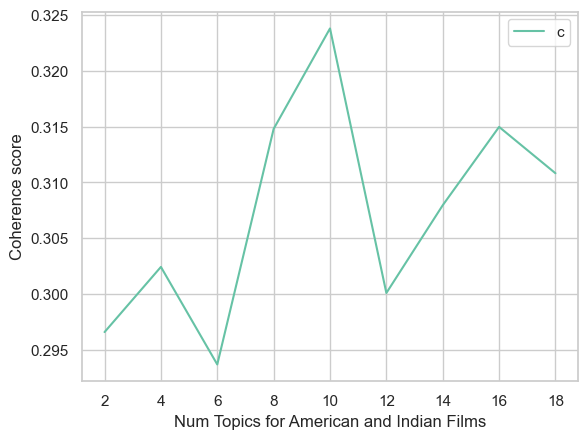

In [375]:
limit=20; start=2; step=2
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics for American and Indian Films")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [376]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2966
Num Topics = 4  has Coherence Value of 0.3024
Num Topics = 6  has Coherence Value of 0.2937
Num Topics = 8  has Coherence Value of 0.3148
Num Topics = 10  has Coherence Value of 0.3238
Num Topics = 12  has Coherence Value of 0.3001
Num Topics = 14  has Coherence Value of 0.308
Num Topics = 16  has Coherence Value of 0.315
Num Topics = 18  has Coherence Value of 0.3108


The coherence score seems optimal for 10 topics number, we therfore chose this as the optimal LDA model.

In [ ]:
# Select the model and print the topics
optimal_model = model_list[4]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

Let us visualize the topics using plDAvis.

In [377]:
import spacy
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline


data = pyLDAvis.gensim_models.prepare(topic_model = optimal_model, corpus = corpus, dictionary = id2word, sort_topics = False)
pyLDAvis.display(data)

/Users/lindadelacombaz/opt/anaconda3/envs/ada/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/lindadelacombaz/opt/anaconda3/envs/ada/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/lindadelacombaz/opt/anaconda3/envs/ada/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/lindadelacombaz/opt/anaconda3/envs/ada/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alterna

In [ ]:
#Saving the plot to put it in the website
pyLDAvis.save_html(data, 'lda.html')

To prepare our features, let us group each summaries (doc) with its respective percentage of contribution to each topic.

In [388]:
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus):
    # Initialize the output
    sent_topics_df = pd.DataFrame()

    # Get the number of topic, percentage of contribution and number the document for each summaries (document)
    for i, row in enumerate(ldamodel[corpus]):

        for j, (topic_num, prop_topic) in enumerate(row):
            
            # Here we append topic_num + 1 to number to match each topics accordingly to pLDAvis' graph
            sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num+1), round(prop_topic,6), int(i)]), ignore_index=True)

    sent_topics_df.columns = ['num_topic', 'topic_perc_contrib','num_document']

    return(sent_topics_df)

sent_topics_df = format_topics_sentences(ldamodel=optimal_model, corpus=corpus)

# Show the documents and their topic contribution
sent_topics_df.head(10)

/var/folders/87/b39tprrs4vgb71j5qj9sq5hw0000gn/T/ipykernel_1586/1334696354.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num+1), round(prop_topic,6), int(i)]), ignore_index=True)
/var/folders/87/b39tprrs4vgb71j5qj9sq5hw0000gn/T/ipykernel_1586/1334696354.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num+1), round(prop_topic,6), int(i)]), ignore_index=True)


,num_topic,topic_perc_contrib,num_document
0,4.0,0.079856,0.0
1,6.0,0.018977,0.0
2,7.0,0.657871,0.0
3,8.0,0.201449,0.0
4,10.0,0.038245,0.0
5,2.0,0.089863,1.0
6,4.0,0.368663,1.0
7,10.0,0.535536,1.0
8,4.0,0.827389,2.0
9,9.0,0.156598,2.0


We then pivot the precedent data frame to have each columns as a topic.

In [390]:
df_topics = sent_topics_df.copy()

# Pivot the data frame
df_topics = df_topics.pivot(index = 'num_document', columns='num_topic', values='topic_perc_contrib')

# Replace every nan to 0 to interpret this a zero contribution to the topic
df_topics = df_topics.replace(np.nan, 0)

# Finally, join with the summaries to have the wikipedia id and the original text of the summaries
df_topics = df_topics.join(summaries_topic)

df_topics.head()

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,wikipedia_movie_id,summaries
num_document,,,,,,,,,,,,
0.0,0.000000,0.000000,0.0,0.079856,0.000000,0.018977,0.657871,0.201449,0.000000,0.038245,20663735,poovalli induchoodan is sentenced for six yea...
1.0,0.000000,0.089863,0.0,0.368663,0.000000,0.000000,0.000000,0.000000,0.000000,0.535536,8388648,the film opens with madhav and sreenu playin...
2.0,0.000000,0.000000,0.0,0.827389,0.000000,0.000000,0.000000,0.000000,0.156598,0.000000,4356664,"kishen has a suspicious-minded wife, kaajal ,..."
3.0,0.078696,0.000000,0.0,0.000000,0.000000,0.032987,0.000000,0.000000,0.144298,0.738187,19174305,"tahaan lives with his grandfather , mother ha..."
4.0,0.000000,0.000000,0.0,0.688170,0.130148,0.000000,0.159704,0.000000,0.000000,0.000000,3459677,"raj mittal , veer saxena and aryan kapoor ar..."


#### Description of the topics

Let us identify the topics and label them. To do that, we have observed every topic bubble and identified the keywords that made sense and were specific to each topic.

This enable us to label in a specific manner each topic and not to give a general genre, since we already have that in our features. It was difficult to pinpoint a specific theme since movies' stories can be very broad and unique, so we decided to chose the keywords as the most relevant to describe the topics.

We therefore came up with a small description for each topics:

- Topic 1: We chose "escape, camp, truck, shoot" as relevant keywords. It seems that this topic talks about action movies that takes place in for a example military camp (keyword camp, truck, shoot, drive) with actions that include violence (keywords escape, reveal, attack, attempt, shoot).

- Topic 2: We chose "team, game, player, coach" as the relavant keywords. The topic seems turned around sports and game and the complex relationships between people that result from the activity (keywords attempt, escape, force). The geographic location seems to take a role in the topic (keyword city, local, world, town).

- Topic 3: "creature, dead, house" made the most sense to depicts the topic. This topic seems to be about supernatural horror (keyword creature) thriller, within a family environement (keywords child, family) probabily in their own house (keywords house, door, room). The thriller part comes from the subject of murder (keywords dead, body, murder, attack).

- Topic 4: "woman, relationship, date, party" were the most sense-making keywords chosen for this topic. It is pretty straightforward that it revolves around the theme of romance and the development of a relationship of two people into something important. The keywords wife, mother, family, together, start and live support this idea.

- Topic 5: The keywords "earth, planet, monster, space, robot" are also pretty straighforwards to draw an idea of the topic. It seems more revolved into fantasy sci-fi movies, probabily involving space adventures, involving also conflict and violence (keywords slave, use, destroy, escape, attack).

- Topic 6: "money, cabin, record, fight" keywords seems to be less straighforward to depict the real subject behind it, but we can imagine something that revolves around money and the conflicts that this latter generates. A movie about having to use violence to have money is possible (keywords fight, attempt, drive, break), along with involving some family members (mother, brother).

- Topic 7: We chose "police, murder, prison, crime, evidence" as relevant keywords to depict the topic. It is also pretty straightforward that the subject is about criminality (keywords murder, crime, drug, gang) and the investigation story that follows. The consequences of the crime are also present: guilty going to prison for his/her acts (keywords prison, officer, guard, release) and possibly trying to escape (keywords plan, escape). 

- Topic 8: "school, student, teacher, family" keywords seems describe a school or college environment, with the relationships and stories that grow within. The family seems to be very represented (keywords brother, family, sister, mother, daughter, husband, child, parent). 

- Topic 9: "family, child, plan, escape, sell" keywords although from first sight could be a happy story around family, but is balanced with the keywords plan, escape, sell. We could rather imagine more a dramatic story that a family has to live through and maybe plan the escape of their current situation by leaving everything behind (keywords escape, move, plan, sell, arrive).

- Topic 10 : "mother,father, alien, night, die" were the keywords that we chose to describe this topic. The stories could take place in a family since mother, father and child were keywords that are found in the topic. The alien keyword could indicates some supernatural part of the movies, along with the some groundbreaking revelations that could impact a seemingly "normal" family (keywords realize, reveal, discover, die).


In [417]:
# Label each topics accordingly
df_topics.columns = ['escape_camp_truck_shoot', 'team_game_player_coach', 'creature_dead_house', 'woman_relationship_date_party', 'earth_planet_monster_space_robot', 'money_fight', 'police_murder_prison_crime_evidence', 'school_student_teacher_family', 'family_child_plan_escape', 'mother_father_alien_night_die', 'wikipedia_movie_id', 'summaries']

df_topics.head()

,escape_camp_truck_shoot,team_game_player_coach,creature_dead_house,woman_relationship_date_party,earth_planet_monster_space_robot,money_fight,police_murder_prison_crime_evidence,school_student_teacher_family,family_child_plan_escape,mother_father_alien_night_die,wikipedia_movie_id,summaries
num_document,,,,,,,,,,,,
0.0,0.000000,0.000000,0.0,0.079856,0.000000,0.018977,0.657871,0.201449,0.000000,0.038245,20663735,poovalli induchoodan is sentenced for six yea...
1.0,0.000000,0.089863,0.0,0.368663,0.000000,0.000000,0.000000,0.000000,0.000000,0.535536,8388648,the film opens with madhav and sreenu playin...
2.0,0.000000,0.000000,0.0,0.827389,0.000000,0.000000,0.000000,0.000000,0.156598,0.000000,4356664,"kishen has a suspicious-minded wife, kaajal ,..."
3.0,0.078696,0.000000,0.0,0.000000,0.000000,0.032987,0.000000,0.000000,0.144298,0.738187,19174305,"tahaan lives with his grandfather , mother ha..."
4.0,0.000000,0.000000,0.0,0.688170,0.130148,0.000000,0.159704,0.000000,0.000000,0.000000,3459677,"raj mittal , veer saxena and aryan kapoor ar..."


#### Creating the features

Let us finally create the features for the indian and american summaries.

In [407]:
topic_features_indian = df_topics.copy()

topic_features_indian = df_topics[df_topics['wikipedia_movie_id'].isin(cut_indian_movies['wikipedia_movie_id'])]

topic_features_indian = topic_features_indian.reset_index().drop(columns = ['summaries', 'num_document'])

topic_features_indian.head()

,escape_camp_truck_shoot,team_game_player_coach,creature_dead_house,woman_relationship_date_party,earth_planet_monster_space_robot,money_fight,police_murder_prison_crime_evidence,school_student_teacher_family,family_child_plan_escape,mother_father_alien_night_die,wikipedia_movie_id
0,0.000000,0.000000,0.0,0.079856,0.000000,0.018977,0.657871,0.201449,0.000000,0.038245,20663735
1,0.000000,0.089863,0.0,0.368663,0.000000,0.000000,0.000000,0.000000,0.000000,0.535536,8388648
2,0.000000,0.000000,0.0,0.827389,0.000000,0.000000,0.000000,0.000000,0.156598,0.000000,4356664
3,0.078696,0.000000,0.0,0.000000,0.000000,0.032987,0.000000,0.000000,0.144298,0.738187,19174305
4,0.000000,0.000000,0.0,0.688170,0.130148,0.000000,0.159704,0.000000,0.000000,0.000000,3459677


In [408]:
topic_features_american= df_topics.copy()

topic_features_american = df_topics[df_topics['wikipedia_movie_id'].isin(cut_american_movies['wikipedia_movie_id'])]

topic_features_american = topic_features_american.reset_index().drop(columns = ['summaries', 'num_document'])

topic_features_american.head()

,escape_camp_truck_shoot,team_game_player_coach,creature_dead_house,woman_relationship_date_party,earth_planet_monster_space_robot,money_fight,police_murder_prison_crime_evidence,school_student_teacher_family,family_child_plan_escape,mother_father_alien_night_die,wikipedia_movie_id
0,0.256322,0.000000,0.437123,0.142576,0.0,0.000000,0.0,0.078523,0.000000,0.083362,1952976
1,0.080736,0.000000,0.000000,0.450645,0.0,0.000000,0.0,0.252099,0.121946,0.092293,24225279
2,0.000000,0.000000,0.000000,0.319375,0.0,0.304161,0.0,0.000000,0.000000,0.369918,15401493
3,0.318202,0.024252,0.000000,0.415934,0.0,0.148787,0.0,0.084962,0.000000,0.000000,1480747
4,0.000000,0.000000,0.000000,0.496787,0.0,0.144684,0.0,0.000000,0.000000,0.346850,4018288


# Sentiment Analysis

In [ ]:
print('The mean length of american summaries is {1:.2f} words and for indian summaries it is {0:.2f} words.'.format(
    np.mean([len(ele.split(' ')) for ele in indian_summaries['summaries']]),
    np.mean([len(ele.split(' ')) for ele in american_summaries['summaries']])
))

In [ ]:
#can take up to 3min to run

#defining analyzer
analyzer = SentimentIntensityAnalyzer()

#computing sentiments for each summary
indian_sentiments = pd.DataFrame([analyzer.polarity_scores(summary) for summary in indian_summaries['summaries']])
american_sentiments = pd.DataFrame([analyzer.polarity_scores(summary) for summary in american_summaries['summaries']])

#adding wikipedia id for future merges
indian_sentiments['wikipedia_movie_id']=indian_summaries['wikipedia_movie_id']
american_sentiments['wikipedia_movie_id']=american_summaries['wikipedia_movie_id']
indian_sentiments.head()

In [ ]:
plt.figure(figsize=(15,7))

sns.histplot(american_sentiments['compound'], alpha =.5, stat = 'density', bins = 10)
sns.histplot(indian_sentiments['compound'], alpha=.5, color = 'orange', stat = 'density', bins = 10)
plt.legend(labels=["American movies","Indian movies"])
plt.xlabel('Movie sentiments\nnegative value indicates negative sentiments ; positive value indicates positive sentiments')
plt.title('Movie sentiments, differenciated by movie coutry')
plt.show()

# Creating features based on actor data

### Creating the output datasets

In [ ]:
df_features_indian_actors = pd.DataFrame({'wikipedia_movie_id':[]})
df_features_american_actors = pd.DataFrame({'wikipedia_movie_id':[]})

In [ ]:
# get the ids of the movies from the summaries
df_features_indian_actors['wikipedia_movie_id']=cut_indian_movies['wikipedia_movie_id']
df_features_american_actors['wikipedia_movie_id']=cut_american_movies['wikipedia_movie_id']

### Getting the mean actor age per gender for each movie

In [ ]:
# getting the mean age per gender for indian and american films
mean_male_actor_age_india = indian_film_male.groupby('wikipedia_movie_id', as_index=False)['actor_age_at_movie_release'].agg({'mean_male_actor_age': np.mean})
mean_female_actor_age_india = indian_film_female.groupby('wikipedia_movie_id', as_index=False)['actor_age_at_movie_release'].agg({'mean_female_actor_age': np.mean})

mean_male_actor_age_america = american_film_male.groupby('wikipedia_movie_id', as_index=False)['actor_age_at_movie_release'].agg({'mean_male_actor_age': np.mean})
mean_female_actor_age_america = american_film_female.groupby('wikipedia_movie_id', as_index=False)['actor_age_at_movie_release'].agg({'mean_female_actor_age': np.mean})


df_features_indian_actors = pd.merge(df_features_indian_actors, mean_male_actor_age_india, on = 'wikipedia_movie_id', how = 'left') 
df_features_indian_actors = pd.merge(df_features_indian_actors, mean_female_actor_age_india, on = 'wikipedia_movie_id', how = 'left')

df_features_american_actors = pd.merge(df_features_american_actors, mean_male_actor_age_america, on = 'wikipedia_movie_id', how = 'left')
df_features_american_actors = pd.merge(df_features_american_actors, mean_female_actor_age_america, on = 'wikipedia_movie_id', how = 'left')


### Getting the mean number of films actors in each movie played in

In [ ]:
# merging the number of films an actor played in with the rest of the film data
all_american_actors_ext = all_american_actors.merge(all_american_actors.actor_name.value_counts().reset_index(), left_on = 'actor_name', right_on = 'index', how = 'left')
all_american_actors_ext = all_american_actors_ext.groupby('wikipedia_movie_id', as_index=False)['actor_name_y'].agg({'average_number_of_films_actors_played_in': np.mean})

all_indian_actors_ext = all_indian_actors.merge(all_indian_actors.actor_name.value_counts().reset_index(), left_on = 'actor_name', right_on = 'index', how = 'left')
all_indian_actors_ext = all_indian_actors_ext.groupby('wikipedia_movie_id', as_index=False)['actor_name_y'].agg({'average_number_of_films_actors_played_in': np.mean})

# merging with features
df_features_american_actors = pd.merge(df_features_american_actors, all_american_actors_ext[['wikipedia_movie_id', 'average_number_of_films_actors_played_in']], on = 'wikipedia_movie_id', how = 'left')
df_features_indian_actors = pd.merge(df_features_indian_actors, all_indian_actors_ext[['wikipedia_movie_id', 'average_number_of_films_actors_played_in']], on = 'wikipedia_movie_id', how = 'left')

### Getting the percent of actress in each movie

In [ ]:
def percent_female(x):
    try:
        return x.value_counts().to_dict()['F']/len(x)
    except:
        return 0

percent_female_american_films = all_american_actors.groupby('wikipedia_movie_id', as_index=False)['actor_gender'].apply(percent_female)
percent_female_american_films.rename(columns = {'actor_gender':'percent_female_cast'}, inplace = True)
percent_female_indian_films = all_indian_actors.groupby('wikipedia_movie_id', as_index=False)['actor_gender'].apply(percent_female)
percent_female_indian_films.rename(columns = {'actor_gender':'percent_female_cast'}, inplace = True)

# merging with features
df_features_american_actors = pd.merge(df_features_american_actors, percent_female_american_films, on = 'wikipedia_movie_id', how = 'left')
df_features_indian_actors = pd.merge(df_features_indian_actors, percent_female_indian_films, on = 'wikipedia_movie_id', how = 'left')

# drop the rows with no wikipedia_movie_id
df_features_american_actors.dropna(subset = ['wikipedia_movie_id'], inplace = True)
df_features_indian_actors.dropna(subset = ['wikipedia_movie_id'], inplace = True)

In [ ]:
# merging with the sentiment data
df_features_american_actors = pd.merge(df_features_american_actors, american_sentiments[['wikipedia_movie_id', 'compound']], on = 'wikipedia_movie_id', how = 'left')
df_features_indian_actors = pd.merge(df_features_indian_actors, indian_sentiments[['wikipedia_movie_id', 'compound']], on = 'wikipedia_movie_id', how = 'left')

# Predicting the average rating

## Pre-processing the features

In [ ]:
test_indian = cut_indian_movies.copy()
#remove {}
test_indian['cleared_movie_genres'] = test_indian['movie_genres'].str[1:-1]

#remove films without genre
test_indian = test_indian.query("cleared_movie_genres != ''")
#test_indian['cleared_movie_genres'] = [ele.split(':')[1] for ele in test_indian['cleared_movie_genres']]

test_american = cut_american_movies.copy()
#remove {}
test_american['cleared_movie_genres'] = test_american['movie_genres'].str[1:-1]
#remove films without genre
test_american = test_american.query("cleared_movie_genres != ''")


In [ ]:
test_american.head()

In [ ]:
movie_genre_imdb =  pd.Series(['action','adventure','animation','biography','comedy','crime','documentary','drama','family',
                              'fantasy','noir','history', 'horror','musical','mystery','romance','sci-fi','short Film',
                              'sport','superhero','thriller','war','western'])
spec_chars = [':', '"', ',', '/m/', 'film']

In [ ]:

for char in spec_chars:
    test_indian['cleared_movie_genres'] = test_indian['cleared_movie_genres'].str.replace(char, '')
    test_indian['cleared_movie_genres'] = test_indian['cleared_movie_genres'].str.replace('  ', ' ')
    test_american['cleared_movie_genres'] = test_american['cleared_movie_genres'].str.replace(char, '')
    test_american['cleared_movie_genres'] = test_american['cleared_movie_genres'].str.replace('  ', ' ')

In [ ]:
genre_dummies_indian = pd.DataFrame()
for char in movie_genre_imdb:
    genre_dummies_indian[char] = pd.Series(test_indian['cleared_movie_genres'].apply(lambda x: pd.Series(x).str.contains(char[:3]).any().astype('int')))
    
genre_dummies_american = pd.DataFrame()
for char in movie_genre_imdb:
    genre_dummies_american[char] = pd.Series(test_american['cleared_movie_genres'].apply(lambda x: pd.Series(x).str.contains(char[:3]).any().astype('int')))

In [409]:
genre_dummies_indian['wikipedia_movie_id'] = test_indian['wikipedia_movie_id']
genre_dummies_american['wikipedia_movie_id'] = test_american['wikipedia_movie_id']
features_indian = pd.merge(genre_dummies_indian, df_features_indian_actors, on= 'wikipedia_movie_id', how = 'right')
features_american = pd.merge(genre_dummies_american, df_features_american_actors, on= 'wikipedia_movie_id', how = 'right')

In [410]:
rating_indian = cut_indian_movies.dropna(subset = 'averageRating')[['wikipedia_movie_id', 'averageRating']]
rating_american = cut_american_movies.dropna(subset = 'averageRating')[['wikipedia_movie_id', 'averageRating']]

In [411]:
features_indian = pd.merge(features_indian, topic_features_indian, on= 'wikipedia_movie_id', how = 'left')
features_american = pd.merge(features_american, topic_features_american, on= 'wikipedia_movie_id', how = 'left')
features_indian = pd.merge(features_indian, rating_indian, on= 'wikipedia_movie_id', how = 'right')
features_american = pd.merge(features_american, rating_american, on= 'wikipedia_movie_id', how = 'right')
features_indian = pd.merge(features_indian, test_indian[['wikipedia_movie_id', 'movie_release_date']], on= 'wikipedia_movie_id', how = 'left')
features_american = pd.merge(features_american, test_american[['wikipedia_movie_id', 'movie_release_date']], on= 'wikipedia_movie_id', how = 'left')

In [413]:
features_indian.dropna(subset='escape_camp_truck_shoot', inplace = True)
features_american.dropna(subset='escape_camp_truck_shoot', inplace = True)
features_indian.iloc[:,0:23] = features_indian.iloc[:,0:23].fillna(0) ; features_indian.iloc[:,24:29] = features_indian.iloc[:,24:29].fillna(features_indian.iloc[:,24:29].mean())
features_american.iloc[:,0:23] = features_american.iloc[:,0:23].fillna(0) ; features_american.iloc[:,24:29] = features_american.iloc[:,24:29].fillna(features_american.iloc[:,24:29].mean())

In [414]:
# to csv
features_indian.to_csv('features_indian.csv', index = False)
features_american.to_csv('features_american.csv', index = False)

# If you don't want to run everything start here !!!

In [ ]:
features_indian = pd.read_csv('features_indian.csv')
features_american = pd.read_csv('features_american.csv')

In [ ]:
features_indian_train = features_indian.drop(['wikipedia_movie_id', 'movie_release_date', 'averageRating'], axis = 1).copy()
features_american_train = features_american.drop(['wikipedia_movie_id', 'movie_release_date', 'averageRating'], axis = 1).copy()

american_ratings = features_american[['averageRating', 'movie_release_date']]
indian_ratings = features_indian[['averageRating', 'movie_release_date']]
#standardize the data
features_indian_train.iloc[:,23:] = (features_indian_train.iloc[:,23:] - features_indian_train.iloc[:,23:].mean())/features_indian_train.iloc[:,23:].std()
features_american_train.iloc[:,23:] = (features_american_train.iloc[:,23:] - features_american_train.iloc[:,23:].mean())/features_american_train.iloc[:,23:].std()

## Linear regression (for p-values)

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [ ]:
features_indian_train.rename(columns={'short Film': 'short', 'sci-fi':'scifi'}, inplace=True)
features_american_train.rename(columns={'short Film': 'short', 'sci-fi':'scifi'}, inplace=True)

In [ ]:
form = 'averageRating ~ ' + ' + '.join('C(' + features_indian_train.columns[:23] + ')') + ' + ' + ' + '.join(features_indian_train.columns[23:])
form2 = 'averageRating ~ ' + ' + '.join('C(' + features_american_train.columns[:23] + ')') + ' + ' + ' + '.join(features_american_train.columns[23:])

In [ ]:
mod = smf.ols(formula=form, data=pd.concat([indian_ratings['averageRating'], features_indian_train], axis = 1)).fit()
mod.summary()

In [ ]:
mod2 = smf.ols(formula=form2, data=pd.concat([american_ratings['averageRating'], features_american_train], axis = 1)).fit()
mod2.summary()

## Support-Vector Machine

In [ ]:
# standardize the data
features_indian_train = (features_indian_train - features_indian_train.mean())/features_indian_train.std()
features_american_train = (features_american_train - features_american_train.mean())/features_american_train.std()

# drop the 'noir' column from both datasets because of a lack of data
features_indian_train.drop('noir', axis = 1, inplace = True)
features_american_train.drop('noir', axis = 1, inplace = True)

In [ ]:
from sklearn.svm import SVR
from sklearn import model_selection, metrics

In [ ]:
svr_indian = SVR(kernel='linear', C=1.0)
svr_indian.fit(features_indian_train, indian_ratings['averageRating'])
print('Mean negative squared error : {:.3f}'.format(np.mean(model_selection.cross_val_score(svr_indian, features_indian_train, indian_ratings['averageRating'], scoring = 'neg_mean_squared_error', cv=5))))

We drop the feature 'noir' because it always 0 for Indian movies and thus lead to NaN when standardizing.

In [ ]:
plt.figure(figsize=(20,10))
plt.bar(features_indian_train.columns, svr_indian.coef_[0])
plt.xticks(rotation=90)
plt.title('Feature weights for Indian Movies')
plt.show()

In [ ]:
svr_american = SVR(kernel='linear', C=1.0)
svr_american.fit(features_american_train, american_ratings['averageRating'])
print('Mean negative squared error : {:.3f}'.format(np.mean(model_selection.cross_val_score(svr_american, features_american_train, american_ratings['averageRating'], scoring = 'neg_mean_squared_error', cv=5))))

In [ ]:
plt.figure(figsize=(20,10))
plt.bar(features_american_train.columns, svr_american.coef_[0])
plt.xticks(rotation=90)
plt.title('Feature weights for American Movies')
plt.show()

In [ ]:
# standardize the coefficients
svr_indian_coef = (svr_indian.coef_[0] - svr_indian.coef_[0].mean())/svr_indian.coef_[0].std()
svr_american_coef = (svr_american.coef_[0] - svr_american.coef_[0].mean())/svr_american.coef_[0].std()

df_diff_features = pd.DataFrame({'feature': features_american_train.columns, 'difference': np.abs(svr_indian_coef) - np.abs(svr_american_coef)})

# bar plot of the difference in feature weights
plt.figure(figsize=(7,10))
plt.title('Difference in feature weights between Indian and American movies')
sns.barplot(x = 'difference', y = 'feature', data = df_diff_features ,order = df_diff_features.sort_values('difference')['feature'], palette = 'Blues_d')
plt.xlim(-1.3, 1.3)
plt.show()

Negative values indicate features that are more important in predicting IMDb rating in american films than in Indian films, and positive values indicate the opposite.

We can see that romance and drama are the genre features that have the biggest impact on IMDb rating in indian films, while horror and adventure have the biggest impact on IMDb rating in american films.

# Visualizing American and Indian movies in lower dimension spaces

In [ ]:
labels = np.append(np.repeat(1, len(features_indian_train)), np.repeat(0, len(features_american_train)))
features = pd.concat([features_indian_train, features_american_train], axis = 0)
years = np.append(features_indian['movie_release_date'], features_american['movie_release_date'])
# standardize the data
features = (features - features.mean())/features.std()

## PCA

In [ ]:
from sklearn.svm import SVC
from sklearn import model_selection, metrics, utils
features_shuffled, labels_shuffled, years_shuffled = utils.shuffle(features, labels, years)
svc = SVC()
train_count = 2500
svc.fit(features_shuffled.iloc[:train_count, :], labels_shuffled[:train_count])
print('We can predict with an F1-score of {:.3f} if a movie is Indian or American'.format(np.mean(model_selection.cross_val_score(svc, features, labels, scoring = 'f1', cv=5))))

This accuracy shows that there is a structure in the data that can be used to predict the country of the movie. We should see this structure in the PCA plot but we don't. Maybe by selecting the most important features we can reveal it?

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=8)
features_red = pca.fit_transform(features)

plt.figure(figsize=(10,7))
plt.scatter(features_red[len(features_indian):,0], features_red[len(features_indian):,1], c = 'blue', s=3, alpha = 0.5, label = 'USA')
plt.scatter(features_red[:len(features_indian),0], features_red[:len(features_indian),1], c = 'orange', s=3, alpha = 0.5, label = 'India')
plt.legend()
plt.title('PCA')
plt.show()

## LDA

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=1)
features_red_lda = lda.fit_transform(features, labels)

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(range(len(features_red_lda)), features_red_lda[:,0], 'o', markersize=3, c='grey')
plt.vlines(x = len(features_indian_train), ymin = min(features_red_lda[:,0]), ymax = max(features_red_lda[:,0]), color = 'red')
plt.text(len(features_indian_train)/2, max(features_red_lda[:,0])*0.9, 'India', fontsize=15)
plt.text(len(features_indian_train) + (len(features_american_train) - len(features_indian_train))/2, max(features_red_lda[:,0])*0.9, 'USA', fontsize=15)
plt.xticks([])
plt.title('LDA')
plt.show()

## Time series

In [ ]:
features_indian_year = features_indian.drop(columns=['wikipedia_movie_id', 'averageRating', 'noir']).groupby('movie_release_date').mean()
features_american_year = features_american.drop(columns=['wikipedia_movie_id', 'averageRating', 'noir']).groupby('movie_release_date').mean()
features_indian_year.rename(columns={'short Film': 'short', 'sci-fi':'scifi'}, inplace=True)
features_american_year.rename(columns={'short Film': 'short', 'sci-fi':'scifi'}, inplace=True)

#standardize the data
features_indian_year = (features_indian_year - features_indian_year.mean())/features_indian_year.std()
features_american_year = (features_american_year - features_american_year.mean())/features_american_year.std()

### Time series analysis with Euclidean distance

In [ ]:
euclidean_dist = np.linalg.norm(features_american_year.loc[features_indian_year.index,:] - features_indian_year, axis=1)
dist_mod = smf.ols('euclidean_dist ~ features_indian_year.index', data=locals()).fit()
plt.figure(figsize=(10,7))
plt.plot(features_indian_year.index, euclidean_dist, 'o', markersize=3)
plt.plot(features_indian_year.index, dist_mod.predict(), 'r')
plt.xlabel('Year\nR^2 = {:.2f}   p-value = {:.3e}   coef = {:.3f}'.format(dist_mod.rsquared ,dist_mod.f_pvalue, dist_mod.params[1]))
plt.ylabel('Euclidean distance')
plt.title('Euclidean distance between Indian and American movies features decreases with time')
plt.show()

In [ ]:
weighted_features_indian_train = pd.concat([features_indian_train.drop(columns='noir').mul(features_indian['averageRating'].values, axis='rows', ), features_indian['movie_release_date']], axis=1)
weighted_features_american_train = pd.concat([features_american_train.drop(columns='noir').mul(features_american['averageRating'].values, axis='rows'), features_american['movie_release_date']], axis=1)

#group per year
weighted_features_indian_train_year = weighted_features_indian_train.groupby('movie_release_date').mean()
weighted_features_american_train_year = weighted_features_american_train.groupby('movie_release_date').mean()
weighted_features_indian_train_year.rename(columns={'short Film': 'short', 'sci-fi':'scifi'}, inplace=True)
weighted_features_american_train_year.rename(columns={'short Film': 'short', 'sci-fi':'scifi'}, inplace=True)

#standardize the data
weighted_features_indian_train_year = (weighted_features_indian_train_year - weighted_features_indian_train_year.mean())/weighted_features_indian_train_year.std()
weighted_features_american_train_year = (weighted_features_american_train_year - weighted_features_american_train_year.mean())/weighted_features_american_train_year.std()

In [ ]:
euclidean_dist_weighted = np.linalg.norm(weighted_features_american_train_year.loc[weighted_features_indian_train_year.index,:] - weighted_features_indian_train_year, axis=1)
dist_mod_weighted = smf.ols('euclidean_dist_weighted ~ weighted_features_indian_train_year.index', data=locals()).fit()
plt.figure(figsize=(10,7))
plt.plot(weighted_features_indian_train_year.index, euclidean_dist_weighted, 'o', markersize=3)
plt.plot(weighted_features_indian_train_year.index, dist_mod_weighted.predict(), 'r')
plt.xlabel('Year\nR^2 = {:.2f}   p-value = {:.3e}   coef = {:.3f}'.format(dist_mod_weighted.rsquared ,dist_mod_weighted.f_pvalue, dist_mod_weighted.params[1]))
plt.ylabel('Euclidean distance')
plt.title('Euclidean distance between Indian and American movies features weighted with ratings decreases with time')
plt.show()

In [ ]:
weighted_features_indian_train_year_genre = weighted_features_indian_train_year.iloc[:,:22]
weighted_features_american_train_year_genre = weighted_features_american_train_year.iloc[:,:22]
euclidean_dist_weighted_genre = np.linalg.norm(weighted_features_american_train_year_genre.loc[weighted_features_indian_train_year_genre.index,:] - weighted_features_indian_train_year_genre, axis=1)
dist_mod_weighted_genre = smf.ols('euclidean_dist_weighted_genre ~ weighted_features_indian_train_year_genre.index', data=locals()).fit()
plt.figure(figsize=(10,7))
plt.plot(weighted_features_indian_train_year_genre.index, euclidean_dist_weighted_genre, 'o', markersize=3)
plt.plot(weighted_features_indian_train_year_genre.index, dist_mod_weighted_genre.predict(), 'r')
plt.xlabel('Year\nR^2 = {:.2f}   p-value = {:.3e}   coef = {:.3f}'.format(dist_mod_weighted_genre.rsquared ,dist_mod_weighted_genre.f_pvalue, dist_mod_weighted_genre.params[1]))
plt.ylabel('Euclidean distance')
plt.title('Euclidean distance between Indian and American movies genres weighted with ratings decreases with time')
plt.show()

In [ ]:
weighted_features_indian_train_year_actor = weighted_features_indian_train_year.iloc[:,22:26]
weighted_features_american_train_year_actor = weighted_features_american_train_year.iloc[:,22:26]
euclidean_dist_weighted_actor = np.linalg.norm(weighted_features_american_train_year_actor.loc[weighted_features_indian_train_year_actor.index,:] - weighted_features_indian_train_year_actor, axis=1)
dist_mod_weighted_actor = smf.ols('euclidean_dist_weighted_actor ~ weighted_features_indian_train_year_actor.index', data=locals()).fit()
plt.figure(figsize=(10,7))
plt.plot(weighted_features_indian_train_year_actor.index, euclidean_dist_weighted_actor, 'o', markersize=3)
plt.plot(weighted_features_indian_train_year_actor.index, dist_mod_weighted_actor.predict(), 'r')
plt.xlabel('Year\nR^2 = {:.2f}   p-value = {:.3e}   coef = {:.3f}'.format(dist_mod_weighted_actor.rsquared ,dist_mod_weighted_actor.f_pvalue, dist_mod_weighted_actor.params[1]))
plt.ylabel('Euclidean distance')
plt.title('Euclidean distance between Indian and American movies actors weighted with ratings decreases with time')
plt.show()

In [ ]:
weighted_features_indian_train_year_topic = weighted_features_indian_train_year.iloc[:,27:]
weighted_features_american_train_year_topic = weighted_features_american_train_year.iloc[:,27:]
euclidean_dist_weighted_topic = np.linalg.norm(weighted_features_american_train_year_topic.loc[weighted_features_indian_train_year_topic.index,:] - weighted_features_indian_train_year_topic, axis=1)
dist_mod_weighted_topic = smf.ols('euclidean_dist_weighted_topic ~ weighted_features_indian_train_year_topic.index', data=locals()).fit()
plt.figure(figsize=(10,7))
plt.plot(weighted_features_indian_train_year_topic.index, euclidean_dist_weighted_topic, 'o', markersize=3)
plt.plot(weighted_features_indian_train_year_topic.index, dist_mod_weighted_topic.predict(), 'r')
plt.xlabel('Year\nR^2 = {:.2f}   p-value = {:.3e}   coef = {:.3f}'.format(dist_mod_weighted_topic.rsquared ,dist_mod_weighted_topic.f_pvalue, dist_mod_weighted_topic.params[1]))
plt.ylabel('Euclidean distance')
plt.title('Euclidean distance between Indian and American movies topics weighted with ratings decreases with time')
plt.show()

In [ ]:
pca_weighted_features = PCA(n_components=10)
pca_weighted_features.fit(pd.concat([weighted_features_indian_train_year, weighted_features_american_train_year]))
weighted_features_indian_red = pca_weighted_features.transform(weighted_features_indian_train_year)
weighted_features_american_red = pca_weighted_features.transform(weighted_features_american_train_year)


plt.figure(figsize=(10,7))
plt.plot(weighted_features_american_train_year.index, weighted_features_indian_red[:,0], 'o', markersize=3, label = 'India')
plt.plot(weighted_features_american_train_year.index, weighted_features_american_red[:,0], 'o', markersize=3, label = 'USA')
plt.legend()
plt.xlabel('Year')
plt.ylabel('PCA component 1')
plt.title('PCA component 1 between Indian and American movies features weighted with ratings explains {:.2f}% of the variance'.format(pca_weighted_features.explained_variance_ratio_[0]*100))
plt.show()

In [ ]:
plt.figure(figsize=(10,7))
plt.bar(weighted_features_american_train_year.columns, pca_weighted_features.components_[0])
plt.xticks(rotation=90)
plt.title('?????????????')
plt.show()

NB : This effect of convergence completely disappears when we don't use the ratings as weights. Moreover the weights are very hardly interpretable here.

### Segregating the genres

In [ ]:
genres = features_indian.columns[:22]
weighted_reg_genre_data = []
w = 1

plt.figure(figsize=(30,10))
plt.subplots_adjust(hspace=0.35)
for genre in genres:
    weighted_features_indian_train_genre = weighted_features_indian_train.drop(columns='movie_release_date').mul(features_indian[genre], axis='rows')
    weighted_features_american_train_genre = weighted_features_american_train.drop(columns='movie_release_date').mul(features_american[genre], axis='rows')

    
    weighted_features_indian_train_year_genre = weighted_features_indian_train_genre.groupby(features_indian['movie_release_date']).mean()
    weighted_features_american_train_year_genre = weighted_features_american_train_genre.groupby(features_indian['movie_release_date']).mean()
    
    euclidean_dist_weighted_genre = np.linalg.norm(weighted_features_american_train_year_genre.iloc[:,:22] - weighted_features_indian_train_year_genre.iloc[:,:22], axis=1)
    euclid_idx = weighted_features_indian_train_year_genre.index[(weighted_features_american_train_year_genre.iloc[:,:22].sum(axis=1) != 0) & (weighted_features_indian_train_year_genre.iloc[:,:22].sum(axis=1) != 0)]
    euclidean_dist_weighted_genre = np.delete(euclidean_dist_weighted_genre, (weighted_features_american_train_year_genre.iloc[:,:22].sum(axis=1) == 0) | (weighted_features_indian_train_year_genre.iloc[:,:22].sum(axis=1) == 0))
    
    
    if (sum(features_indian[genre]==1)<100 or sum(features_american[genre]==1)<100):
        continue
    
    
    if (len(euclid_idx)>1):
        plt.subplot(2,4,w)
        plt.title(genre)
        plt.plot(euclid_idx, euclidean_dist_weighted_genre, 'o', markersize=3)
        dist_mod_weighted_genre = smf.ols('euclidean_dist_weighted_genre ~ euclid_idx', data=locals()).fit()
        weighted_reg_genre_data.append([genre, dist_mod_weighted_genre.rsquared ,dist_mod_weighted_genre.f_pvalue, dist_mod_weighted_genre.params[1], sum(features_indian[genre]==1), sum(features_american[genre]==1)])

        plt.plot(euclid_idx, dist_mod_weighted_genre.predict(), 'r')
        plt.xlabel('Year\nR^2 = {:.2f}   p-value = {:.3e}   coef = {:.3f}'.format(dist_mod_weighted_genre.rsquared ,dist_mod_weighted_genre.f_pvalue, dist_mod_weighted_genre.params[1]))
        w+=1
    plt.ylabel('Euclidean distance')
plt.show()

weighted_reg_genre_data = pd.DataFrame(weighted_reg_genre_data, columns=['genre', 'R^2', 'p-value', 'coef', 'India', 'USA'])

Euclidean distance between Indian and American movies weighted with ratings decreases with time in all genres

In [ ]:
weighted_reg_genre_data

In [ ]:
genres = features_indian.columns[:22]
reg_genre_data = []
w = 1


plt.figure(figsize=(30,10))
plt.subplots_adjust(hspace=0.35)
for genre in genres:
    features_indian_train_genre = features_indian_train.mul(features_indian[genre], axis='rows')
    features_american_train_genre = features_american_train.mul(features_american[genre], axis='rows')

    features_indian_train_year_genre = features_indian_train_genre.groupby(features_indian['movie_release_date']).mean()
    features_american_train_year_genre = features_american_train_genre.groupby(features_indian['movie_release_date']).mean()

    euclidean_dist_genre = np.linalg.norm(features_american_train_year_genre.iloc[:,:22] - features_indian_train_year_genre.iloc[:,:22], axis=1)
    euclid_idx = features_indian_train_year_genre.index[(features_american_train_year_genre.iloc[:,:22].sum(axis=1) != 0) & (features_indian_train_year_genre.iloc[:,:22].sum(axis=1) != 0)]
    euclidean_dist_genre = np.delete(euclidean_dist_genre, (features_american_train_year_genre.iloc[:,:22].sum(axis=1) == 0) | (features_indian_train_year_genre.iloc[:,:22].sum(axis=1) == 0))
    
    
    if (sum(features_indian[genre]==1)<100 or sum(features_american[genre]==1)<100):
        continue
    
    
    if (len(euclid_idx)>1):
        plt.subplot(2,4,w)
        plt.title(genre)
        plt.plot(euclid_idx, euclidean_dist_genre, 'o', markersize=3)
        dist_mod_genre = smf.ols('euclidean_dist_genre ~ euclid_idx', data=locals()).fit()
        reg_genre_data.append([genre, dist_mod_genre.rsquared ,dist_mod_genre.f_pvalue, dist_mod_genre.params[1], sum(features_indian[genre]==1), sum(features_american[genre]==1)])

        plt.plot(euclid_idx, dist_mod_genre.predict(), 'r')
        plt.xlabel('Year\nR^2 = {:.2f}   p-value = {:.3e}   coef = {:.3f}'.format(dist_mod_genre.rsquared ,dist_mod_genre.f_pvalue, dist_mod_genre.params[1]))
        w+=1
    plt.ylabel('Euclidean distance')
plt.show()

reg_genre_data = pd.DataFrame(reg_genre_data, columns=['genre', 'R^2', 'p-value', 'coef', 'India', 'USA'])

Weighting with ratings does not change the trend of the decrease of the euclidean distance between Indian and American movies in all genres

In [ ]:
reg_genre_data

### Reducing the american dataset to the same size as the indian dataset

In [ ]:
sampled_american_features_year = pd.DataFrame(index=features_indian_year.index, columns=features_indian_train.columns)
for i in features_indian['movie_release_date'].unique():
    sampled_american_features_year.loc[i,:] = features_american_train[features_american['movie_release_date']==i].sample(sum(features_indian['movie_release_date']==i)).mean()
sampled_american_features_year.dropna(inplace=True, axis=0)

In [ ]:
euclidean_dist_sampled = np.linalg.norm(sampled_american_features_year.to_numpy().astype(float) - features_indian_year.to_numpy().astype(float), axis=1)
dist_mod_sampled = smf.ols('euclidean_dist_sampled ~ features_indian_year.index', data=locals()).fit()
plt.figure(figsize=(10,7))
plt.plot(features_indian_year.index, euclidean_dist_sampled, 'o', markersize=3)
plt.plot(features_indian_year.index, dist_mod_sampled.predict(), 'r')
plt.xlabel('Year\nR^2 = {:.2f}   p-value = {:.3e}   coef = {:.3f}'.format(dist_mod_sampled.rsquared ,dist_mod_sampled.f_pvalue, dist_mod_sampled.params[1]))
plt.ylabel('Euclidean distance')
plt.title('The decreasing distance between Indian and American movies is also kept when we sample American movies to match the number of Indian movies')
plt.show()

Note: the variance is increased when we reduce the number of American movies.

### Time series analysis with PCA

In [ ]:
plt.figure(figsize=(10,7))
features_indian_year_red = pca.transform(features_indian_year)
features_american_year_red = pca.transform(features_american_year)
plt.plot(features_indian_year.index, features_indian_year_red[:,0], 'o', markersize=3, c='orange', label = 'India')
plt.plot(features_american_year.index, features_american_year_red[:,0], 'o', markersize=3, c='blue', label = 'USA')
plt.legend()
plt.title('PCA')
plt.xlabel('Year')
plt.ylabel('PC1')
plt.show()

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(features_indian_year_red[:,0], features_indian_year_red[:,1], 'o', markersize=3, c='orange', label = 'India')
plt.plot(features_american_year_red[:,0], features_american_year_red[:,1], 'o', markersize=3, c='blue', label = 'USA')
plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA')
plt.show()

In [ ]:
diff_features_year = np.abs(pca.transform(features_american_year.loc[features_indian_year.index,:])[:,0] - features_indian_year_red[:,0])
plt.figure(figsize=(10,7))
plt.plot(features_indian_year.index, diff_features_year, 'o', markersize=3)
plt.title('Difference between PC1 of Indian and American movies features across time')
plt.xlabel('Year')
plt.ylabel('PC1 difference')
plt.show()

### Time series analysis with LDA

In [ ]:
plt.figure(figsize=(10,7))
features_indian_year_lda = lda.transform(features_indian_year)
features_american_year_lda = lda.transform(features_american_year)
plt.plot(features_indian_year.index, features_indian_year_lda[:,0], 'o', markersize=3, c='orange', label = 'India')
plt.plot(features_american_year.index, features_american_year_lda[:,0], 'o', markersize=3, c='blue', label = 'USA')
plt.legend()
plt.title('LDA')
plt.xlabel('Year')
plt.ylabel('LDA1')
plt.show()

In [ ]:
diff_features_year_lda = np.abs(lda.transform(features_american_year.loc[features_indian_year.index,:])[:,0] - features_indian_year_lda[:,0])
lda_mod = smf.ols('diff_features_year_lda ~ features_indian_year.index', data=locals()).fit()
plt.figure(figsize=(10,7))
plt.plot(features_indian_year.index, diff_features_year_lda, 'o', markersize=3)
plt.plot(features_indian_year.index, lda_mod.predict(), 'r')
plt.xlabel('Year\nR^2 = {:.2f}   p-value = {:.3e}   coef = {:.3f}'.format(lda_mod.rsquared ,lda_mod.f_pvalue, lda_mod.params[1]))
plt.title('Difference between LDA1 of Indian and American movies features across time')
plt.ylabel('LDA1 difference')
plt.show()

## Analysis of feature importances across 3 periodes

In [ ]:
cuts = [1960, 1970, 1980, 1990, 2000, 2005]

svr = SVR(kernel='linear', C=1.0)

def compute_coefs(feats, rats, cuts):
    coefs = np.zeros((len(cuts)+1, feats.shape[1]))
    counts=[sum(rats['movie_release_date'] < cuts[0])]
    svr.fit(feats.loc[rats['movie_release_date'] < cuts[0] ,:], rats.loc[rats['movie_release_date'] < cuts[0], 'averageRating'])
    coefs[0,:] = svr.coef_
    for i in range(len(cuts)-1):
        svr.fit(feats.loc[(rats['movie_release_date'] >= cuts[i]) & (rats['movie_release_date'] < cuts[i+1]) ,:], rats.loc[(rats['movie_release_date'] >= cuts[i]) & (rats['movie_release_date'] < cuts[i+1]), 'averageRating'])
        coefs[i+1,:] = svr.coef_
        counts.append(sum((rats['movie_release_date'] >= cuts[i]) & (rats['movie_release_date'] < cuts[i+1])))
    svr.fit(feats.loc[rats['movie_release_date'] >= cuts[1] ,:], rats.loc[rats['movie_release_date'] >= cuts[1], 'averageRating'])
    coefs[-1,:] = svr.coef_
    counts.append(sum(rats['movie_release_date'] >= cuts[1]))
    return coefs, counts

indian_coef, indian_counts = compute_coefs(features_indian_train, indian_ratings, cuts)
american_coef, american_counts = compute_coefs(features_american_train, american_ratings, cuts)

In [ ]:
coef_diff = np.linalg.norm(american_coef - indian_coef, axis=1)
x = np.append('1950-'+str(cuts[0]), [str(cuts[i]) + '-' + str(cuts[i+1]) for i in range(len(cuts)-1)])
x = np.append(x, str(cuts[-1]) + '-2010')
plt.figure(figsize=(10,7))
plt.plot(x, coef_diff, markersize=3)
plt.title('Euclidean distance in SVR coefficients between Indian and American movies features does not seem to decrease with time')
plt.xlabel('Time period')
plt.ylabel('Euclidean distance')
plt.show()

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(x, indian_counts, markersize=3, c='orange', label = 'India')
plt.plot(x, american_counts, markersize=3, c='blue', label = 'USA')
plt.legend()
plt.xlabel('Time period')
plt.ylabel('Number of movies')
plt.title('Number of movies in each time period is very unequal')
plt.show()

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(x, np.abs(indian_coef-american_coef), markersize=3, label = features_indian_train.columns)
plt.xlabel('Time period')
plt.ylabel('Absolute difference in SVR coefficients')
plt.title('Absolute difference in SVR coefficients between Indian and American movies features does not seem to converge')
plt.legend()
plt.show()